In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive
import os
os.chdir('drive/Colab Notebooks')
print(os.getcwd())

E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 CNN.ipynb  'Colab Notebooks'   delta.ipynb  'dif&surf.ipynb'
/content/drive/Colab Notebooks


In [0]:
import torch

import torch.nn.functional as F
import torch.nn as nn
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

CLASS_NUM = 5

In [0]:
class NN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(6000*2000*1, 40)
        self.hidden2 = nn.Linear(40, 200)
        self.dp = nn.Dropout(0)
        self.actv = nn.Sigmoid()
        self.output = nn.Linear(200, CLASS_NUM)

    def forward(self, x):
        x = x.view(1, -1)
        x = self.hidden(x)
        x = self.dp(x)
        x = self.actv(x)
        
        x = self.hidden2(x)
        x = self.dp(x)
        x = self.actv(x)
        x = self.output(x)
        return x
# class NN_Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden = nn.Linear(6000*2000*1, 40)
#         self.dp = nn.Dropout(0.5)
#         self.actv = nn.Sigmoid()
#         self.output = nn.Linear(40, CLASS_NUM)

#     def forward(self, x):
#         x = x.view(1, -1)
#         x = self.hidden(x)
#         x = self.dp(x)
#         x = self.actv(x)
#         x = self.output(x)
#         return x

In [21]:
if __name__ == '__main__':
    plt.ion()
    if_cuda = True

    transform = transforms.Compose([
        # transforms.Resize(),
        transforms.Grayscale(),
        transforms.ToTensor(),      # 转换为Tensor&归一化至[0,1]
        transforms.Normalize(mean = [.5], std = [.5]) # 标准化
    ])

    train_dataset = ImageFolder('data2/train/', transform = transform)
    val_dataset = ImageFolder('data2/val/', transform = transform)
    test_dataset = ImageFolder('data2/test/', transform = transform) + val_dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    print(train_dataset.class_to_idx)

{'Agent': 0, 'Dofloo': 1, 'Lady': 2, 'Mayday': 3, 'normal': 4}


In [22]:
    model = NN_Model()
    epo = 20

    if if_cuda: 
        model.cuda()
        loss_function = nn.CrossEntropyLoss().cuda()
    else:
        loss_function = nn.CrossEntropyLoss()

#     optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay= 1e-5, momentum = 0.1, nesterov = True)
    lr = 4e-4
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []

    for epoch in range(epo):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []

        model.train()
        for data, target in train_loader:
            if if_cuda: 
                data = data.cuda()
            optimizer.zero_grad()
            output = model(data)
            if if_cuda: 
                target = target.cuda()
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            pre = output.argmax(dim=1)
            train_acc.append(pre.item() == target.item())

        model.eval()
        for data, target in val_loader:
            if if_cuda: 
                data = data.cuda()
            output = model(data)
            if if_cuda: 
                target = target.cuda()
            loss = loss_function(output, target)
            valid_loss.append(loss.item())
            pre = output.argmax(dim=1)
            valid_acc.append(pre.item() == target.item())
        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss), "Train Accuracy: ", np.mean(train_acc), "Valid Accuracy: ", np.mean(valid_acc))
        train_loss_list.append(np.mean(train_loss))
        valid_loss_list.append(np.mean(valid_loss))
        train_acc_list.append(np.mean(train_acc))
        valid_acc_list.append(np.mean(valid_acc))
        if epoch > 5:
            if epoch % 5 == 0:
                lr /= 2
                print("lr/=2, lr= ", lr)
                optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
            


Epoch: 0 Training Loss:  1.5063255258968897 Valid Loss:  1.2905414077368649 Train Accuracy:  0.4642857142857143 Valid Accuracy:  0.6363636363636364
Epoch: 1 Training Loss:  1.1770923605987005 Valid Loss:  1.1740660125559026 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 2 Training Loss:  1.0869946352073125 Valid Loss:  1.1804181662472812 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 3 Training Loss:  1.0468162383352007 Valid Loss:  1.1746617826548489 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 4 Training Loss:  0.9871236043316978 Valid Loss:  1.2015822475606746 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 5 Training Loss:  0.9212515737329211 Valid Loss:  1.2078029757196254 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 6 Training Loss:  0.882930977003915 Valid Loss:  1.2241419445384631 Train Accuracy:  0.5714285714285714 V

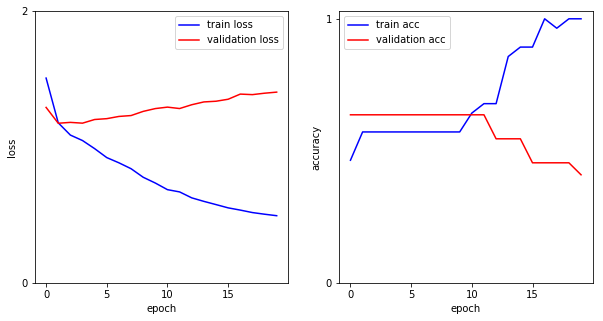

4 4 True
4 1 False
4 0 False
4 4 True
2 4 False
0 4 False
4 4 True
4 0 False
1 3 False
4 4 True
1 1 True
4 4 True
4 3 False
0 4 False
1 4 False
4 4 True
0 4 False
4 4 True
4 2 False
4 2 False
4 4 True
0 4 False
0.4090909090909091


In [24]:
x = range(epo)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
l1, = plt.plot(x, train_loss_list, '-b')
l2, = plt.plot(x, valid_loss_list, '-r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([l1, l2], ['train loss', 'validation loss'], loc='best')
plt.yticks([0, 2])


plt.subplot(1, 2, 2)
l1, = plt.plot(x, train_acc_list, '-b')
l2, = plt.plot(x, valid_acc_list, '-r')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([l1, l2], ['train acc', 'validation acc'], loc='best')
plt.yticks([0, 1])

plt.show()

accuracy = []
for data, target in val_loader:
    if if_cuda: 
        data = data.cuda()
        target = target.cuda()
    output = model(data.float())
    pre = output.argmax(dim=1)
    print(pre.item(), target.item(), pre.item() == target.item())
    accuracy.append(pre.item() == target.item())
print(np.mean(accuracy))